### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

2024-07-10 20:54:53.756708: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 20:54:53.898713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 20:54:53.967352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 20:54:53.967785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 20:54:54.071140: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
processed_texts += processed_val_texts
labels = np.concatenate([labels, val_labels])

In [5]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [6]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

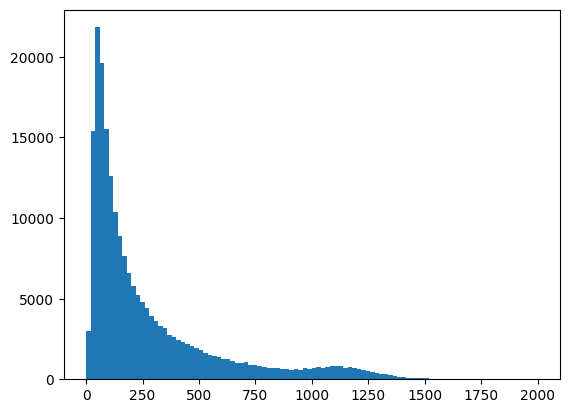

In [7]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [8]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

2024-07-10 20:54:55.700089: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 20:54:55.726298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 20:54:55.733061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
vectorized_texts = vectorize_layer(processed_texts)

In [10]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Creating the model

In [11]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC()
svm_clf.fit(vectorized_texts, labels)

LinearSVC()

### Evaluating the Model

In [12]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

In [13]:
y_pred = svm_clf.predict(vectorized_test_texts)
y_pred

array([1, 0, 0, ..., 0, 1, 0], dtype=int16)

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print()

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')


False Positive Rate: 0.2169
False Negative Rate: 0.3420

accuracy_score 0.721
precision_score 0.749
recall_score 0.658
f1_score 0.701


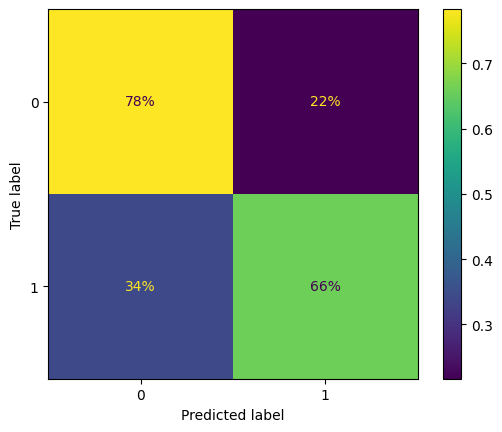

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()

In [16]:
import pickle

with open('./models/svm_clf.pkl', 'wb') as fp:
  pickle.dump(svm_clf, fp)